In [35]:
import os
import pandas as pd
import matplotlib
import numpy as np
from scipy.stats import binom, chisquare, chi2

wd = os.path.dirname(os.getcwd())

In [36]:
no_mask = pd.read_csv(wd+'/data/no_mask_no_vacc_10k.csv')

# Question 1
What is the distribution of the number of kids that Tommy infects on Day 1?

First, pivot the raw data and return a dataframe that shows the number

In [37]:
def get_infected_count(day, df):
    df = df.loc[no_mask['day'] == day]
    pivot_tbl = pd.pivot_table(
        df,
        index=['contagious'],
        values='trial',
        aggfunc=["count"],
    ).reset_index()
    pivot_tbl.columns = ['contagious', 'count']
    pivot_tbl['percent'] = pivot_tbl['count']/pivot_tbl['count'].sum()
    return df, pivot_tbl


day_1_df, day_1_observed = get_infected_count(1, no_mask)
day_1_observed

,contagious,count,percent
0,1.0,5566,0.5566
1,2.0,3295,0.3295
2,3.0,941,0.0941
3,4.0,171,0.0171
4,5.0,25,0.0025
5,6.0,2,0.0002


Now, plot a histogram of the frequencies that the number of infected appears on each day.

<Axes: >

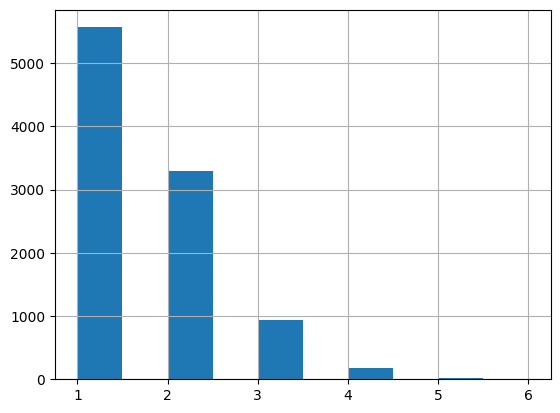

In [38]:
day_1_df['infected'].hist()

Now, plot what a binomial(30, .02) distribution would look like

<Axes: xlabel='bucket'>

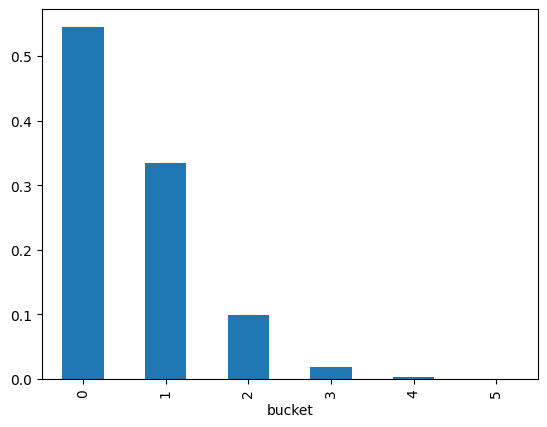

In [39]:
def binomial_buckets(n, p, k):
    df = pd.DataFrame()
    df['bucket'] = np.arange(n + 1)
    df['frequency'] = binom.pmf(np.arange(n + 1), n, p)
    df['frequency'] = df['frequency']
    df['population'] = round(df['frequency']*k,0)

    return df.set_index('bucket')

day_1_expected = binomial_buckets(30, .02, no_mask.trial.max()).loc[:5,:]

day_1_expected['frequency'].plot(kind='bar')


Visual inspection tells us our hypothesis may be correct, and to reject the null hypothesis that the distribution is not binoial(30, .02). To confirm this, we will do a chi squared test to confirm our hypothesis.

The sum of the population column may not equal the number of trials we had due to rounding, so we alter the last record to reflect the last bucket to have the remaining number of trials.

In [40]:
day_1_expected['population'].sum()

10000.0

In [55]:
observed = day_1_observed['count']
expected = day_1_expected['population'].astype(int)
chi_sq = chisquare(observed,expected)
print(f'Test Statistic: {round(chi_sq[0],2)} \nP-value = {round(chi_sq[1],2)}')

Test Statistic: 7.01 
P-value = 0.22


In [48]:
crit_val = chi2.ppf(1-.05, 6)
print(f'Critical x^2 value = {crit_val}')

Critical x^2 value = 12.591587243743977


The Chi Square test statistic is less than the significant value at a .05% confidence level, and the p-value is greater than .05. Thus, we fail to reject the null hypothesis that the distirbution of students infected on day 1 is distributed as binomial(30, .02)